# Recurrent Network Trader
James Chan 2018

## Overview
Deep learning as shown incredible strength in problems that involve forecasting. A particular type of deep learning which specializes in time-series data (e.g. audio, sentences, and stock) is the recurrent network.  In this exericse we will apply recurrent network towards the domain of stock trading. 

#### Recurrent Network Representation and LSTM
Recurrent network is particular useful when input data contains time-series property.  Figure 1 shows the basic architecture of a single layer recurrent network.  Xt and is the input value at time t, which gets fed back to the network in the next time step along with the activation at timie t. The amazing thing about recurrent network is that it shares parameters between time steps.  This is similiar to the use of filter in convolutional network 
![](files/img/rnn_architecture.png)
<center><b>Figure 1. RNN Architecture</b></center>

Some of the examples of X:
* The sentence "Hi, how are you" can be broken into characters where t at 1, 2, 3,...,N maps to X values of "H", "i", ",",...,"u".
* Alternatively, t at 1,2,3,4 can be mapped to individual words for X as such "Hi", ",", "how", "are".
* At day = 1,2,3,4 stock market technical indicator such as Price/SMA Ratio can a single value fo reach of the four days.

Some examples of Y:
* A many-to-one relationship between X and Y such as when X is a product review and Y is the review in number of stars
* A many-to-many relationship where X is a sentence in English and Y is the corresponding language translation in French
* A many-to-one relationship where X is a series of stock technical indicator values and Y is a buy or sell signal.

LSTM is a more sophisticated version of the RNN. It keeps a memory of information from earlier time-steps, which then get fed into the network at later time steps.  This memory helps carry information from earlier time steps to later time steps, and hence enables a more complex modeling of a sequence model.  LSTM is a tough concept to grasp in my opinion, please refer to other online material for further learning.

### Table of Content
1. Framing the Problem
2. Create the Model
3. Fit the Model
4. Back Test
5. Conclusion

In [132]:
import pandas as pd
from trader_utils import BackTester, predictions_to_trades, get_xy
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers
import numpy as np

# from sklearn.preprocessing import StandardScaler
%matplotlib inline

## 1. Framing the Problem
In the Deep Learning Trader, we use technical indicator values as our input feature and N-day return as our labels. This formulation is not applicable for RNN. Here we are using a similiar approach, but we also include the all the indicator values T days leading up to a given trading day.  

### Fully Connected Network Samples Formulation

![](files/img/fullyconnected.png)
<center><b>Figure 2. Fully Connected Network Samples Formulation</b></center> 
Recall previously our Deep Learning Trader takes takes indicator values of each day as the input feature and the N-day return as the labels.  This formulation serves well for fully connected network, but does not apply to recurrent network since it does not have a time-series property.

### Recurrent Network Samples Formulation

![](files/img/rnnframe1.png)
<center><b>Figure 3. RNN Samples Formulation</b></center> 
In Recurrent Network, we take the indicator values of T previous time steps into account as well.  In Figure 3 we are using a T of 4, meaning the indicator values of the four previous trading days are also being accounted for.  This formulation also take advantage of having N-day return as the labels.

### Recurrent Network Samples Visualized

![](files/img/rnnframe2.png)
<center>Figure 4. Fully Connected Network Samples</center> 

## 2. Create the Model
After a little bit of tuning, I found the below parameters to work quite well in-sample. The code has been refactored since its previous rendition with most of the heavy lifting encapsulated into traders_utils.py.  This improvement allows for reusability across different types of traders I have been developing.
1. Indicators of P/SMA Ratio, Bollinger Bands, and Volatility with a rolling window of 21. 
2. Time steps of 7.
3. N-day return where N = 1
4. LSTM network with an input layer of 64 nodes and 4 hidden layers of 64 nodes.  
5. Activation function of relu for all hidden and input layers.  Tanh for output layer.
6. Dropout probability of .3
7. Binary cross-entropy as the loss function and Adam for backprop
8. 500 epochs with full batches.

In [114]:
class RNNTrader:
    def __init__(self):
        self.n = 1
        self.rolling_window = 21
        self.ticker = None
        self.timesteps = 7
    
    def fit(self, ticker, start_date, end_date): 
        self.ticker = ticker
        train_x, train_y = get_xy(ticker, start_date, end_date, self.rolling_window, self.n)
        num_examples = train_x.shape[0] - self.timesteps + 1
        num_features = train_x.shape[1]
        #format samples into dimension shown in Figure 4.
        examples = np.zeros((num_examples, self.timesteps, num_features))
        for i in range(num_examples):
            examples[i,:,:] = train_x[i:i+self.timesteps,:]
        Y = train_y[self.timesteps-1:]
        
        #construct LSTM network in Keras
        model = Sequential()
        model.add(LSTM(64, input_shape=(self.timesteps, num_features), activation='relu', return_sequences=False))
        for i in range(4):
            model.add(Dense(64, activation='relu'))
            model.add(Dropout(.3))
        model.add(Dense(1, activation='tanh'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        #fit the model
        model.fit(examples, Y, epochs=500, verbose=0)
        
        #store the model
        self.model = model
    
    def generate_trades(self, start_date, end_date):
        #format testing samples into dimension shown in Figure 4.
        test_x, _ = get_xy(self.ticker, start_date, end_date, self.rolling_window, self.n)
        num_examples = test_x.shape[0] - self.timesteps + 1
        num_features = test_x.shape[1]
        examples = np.zeros((num_examples, self.timesteps, num_features))
        for i in range(num_examples):
            examples[i,:,:] = test_x[i:i+self.timesteps,:]
            
        #make predictions
        predictions = self.model.predict_classes(examples)
        actual_start = self.rolling_window - 1 + self.timesteps - 1
        
        #convert prediction to trades
        trades = predictions_to_trades(self.ticker, predictions, start_date, end_date, self.n, actual_start)
        return trades

## 3. Fit the Model
Here we intialize the learner and define some test cases for it

In [115]:
#initialize
rnnt = RNNTrader()

In [121]:
#define test cases

#test 1 case GOOG
in_sd = pd.datetime(2008,1,1)
in_ed = pd.datetime(2010,12,31)
out_sd = pd.datetime(2010,1,1)
out_ed = pd.datetime(2012,12,31)
ticker = 'GOOG'

#test 2 case JPM
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'JPM'

# #test 3 case AMZN
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'AMZN'

# #test 4 case AAPL
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'AAPL'


In [122]:
#train model
rnnt.fit(ticker, in_sd, in_ed)    

## 4. Back Test
Let's see how our RNN Trader perform.

In [123]:
#intialize backtester
starting_cash = 100000
holding_limit = 1000
btr = BackTester(starting_cash, holding_limit)

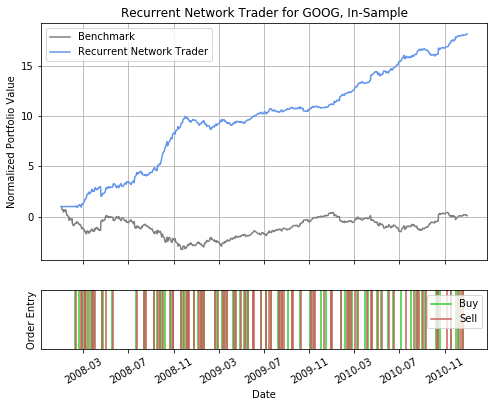

In [124]:
#generate trade in-sample
df_trades = rnnt.generate_trades(in_sd, in_ed) 

plot_title = 'Recurrent Network Trader for {}, In-Sample'.format(ticker)
algorithm_title = 'Recurrent Network Trader'
btr.backtest(df_trades, plot_title, algorithm_title, benchmark=True, plot_size=(8,6))

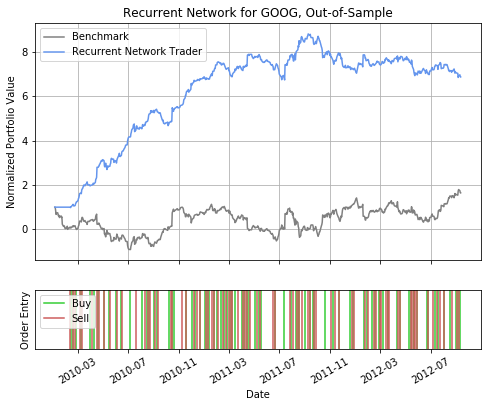

In [133]:
#out-of-sample
start_date = pd.datetime(2012,1,1)
end_date = pd.datetime(2012,12,31)

#generate trade out-of-sample
df_trades = rnnt.generate_trades(out_sd, out_ed) 
plot_title = 'Recurrent Network for {}, Out-of-Sample'.format(ticker)
algorithm_title = 'Recurrent Network Trader'
btr.backtest(df_trades, plot_title, algorithm_title, benchmark=True, plot_size=(8,6)) 

## Conclusion
Both the in-sample and out-of-sample performance for GOOG are phenonomenal.  As always, we must rigorously back test out-of-sample models in order to validate the the integrity of the model. I do believe that recurrent network has the ability to provide forecast at a much higher accuracy than other variants of deep learning models when trained with large enough of data.